
#  **XGBoost**

**XGBoost** (Extreme Gradient Boosting) is a fast, scalable library for gradient-boosted decision trees.

**Topics:**
- Install & import
- Classification & Regression (scikit-learn API)
- Early stopping
- Low-level `DMatrix` / `xgb.train`
- Cross-validation with `xgb.cv`
- Feature importance
- Handling missing values & (optional) categorical features
- Save & load models


## 1) Install & Imports

In [1]:

# If running on fresh Colab
# !pip install -U xgboost scikit-learn matplotlib pandas numpy
# !pip install -U xgboost
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.datasets import load_iris, fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("xgboost version:", xgb.__version__)


xgboost version: 3.0.4


## 2) Quickstart: Classification (Iris)

Best iteration based on eval set (mlogloss): 71
Accuracy: 0.9666666666666667

Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



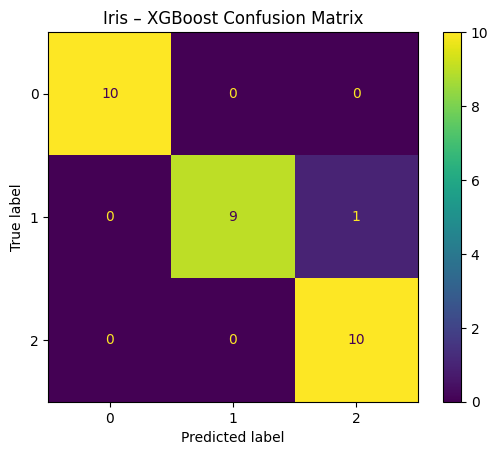

In [2]:
# Data
iris = load_iris(as_frame=True)
X, y = iris.data, iris.target

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Model (sane defaults; tweak n_estimators / max_depth / learning_rate)
clf = XGBClassifier(
    n_estimators=300, # Train for a sufficient number of estimators
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective="multi:softprob",
    eval_metric="mlogloss",
    random_state=42
)

# Train the model and get evaluation results
evals_result = clf.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False # Keep training quiet
).evals_result() # Get evaluation results

# Manually find the best iteration based on the eval metric (mlogloss)
# The evals_result() returns a dict like {'validation_0': {'mlogloss': [...], ...}, 'train': ...}
eval_metric_values = evals_result['validation_0']['mlogloss']
best_iteration = np.argmin(eval_metric_values)
print(f"Best iteration based on eval set (mlogloss): {best_iteration}")

# Evaluate using the best iteration
# Note: iteration_range is [start, end) so we need best_iteration + 1
pred = clf.predict(X_test, iteration_range=(0, best_iteration + 1))
proba = clf.predict_proba(X_test, iteration_range=(0, best_iteration + 1))


print("Accuracy:", accuracy_score(y_test, pred))
print("\nClassification Report:\n", classification_report(y_test, pred, target_names=iris.target_names))

ConfusionMatrixDisplay(confusion_matrix(y_test, pred)).plot()
plt.title("Iris – XGBoost Confusion Matrix")
plt.show()

## 3) Quickstart: Regression (California Housing)

In [3]:
cal = fetch_california_housing(as_frame=True)
Xr, yr = cal.data, cal.target

Xr_tr, Xr_te, yr_tr, yr_te = train_test_split(Xr, yr, test_size=0.2, random_state=42)

reg = XGBRegressor(
    n_estimators=600, # Train for a sufficient number of estimators
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective="reg:squarederror",
    eval_metric="rmse", # Include eval_metric here for evaluation results
    random_state=42
)

# Train the model without early stopping callback
results = reg.fit(
    Xr_tr, yr_tr,
    eval_set=[(Xr_te, yr_te)],
    verbose=False # Keep training quiet
)

# Get evaluation results
evals_result = results.evals_result()

# Manually find the best iteration based on the eval metric (rmse)
# The evals_result() returns a dict like {'validation_0': {'rmse': [...], ...}, 'train': ...}
eval_metric_values = evals_result['validation_0']['rmse']
best_iteration = np.argmin(eval_metric_values)
print(f"Best iteration based on eval set (rmse): {best_iteration}")

# Evaluate using the best iteration
# Note: iteration_range is [start, end) so we need best_iteration + 1
pred = reg.predict(Xr_te, iteration_range=(0, best_iteration + 1))

# Calculate RMSE manually by taking the square root of MSE
mse = mean_squared_error(yr_te, pred)
rmse = np.sqrt(mse)

mae  = mean_absolute_error(yr_te, pred)
r2   = r2_score(yr_te, pred)
print(f"RMSE: {rmse:.4f}  |  MAE: {mae:.4f}  |  R²: {r2:.4f}")

Best iteration based on eval set (rmse): 595
RMSE: 0.4400  |  MAE: 0.2883  |  R²: 0.8523


## 4) Low-level API: `DMatrix` + `xgb.train` (fine control)

In [4]:

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest  = xgb.DMatrix(X_test,  label=y_test)

params = {
    "objective": "multi:softprob",
    "num_class": len(np.unique(y)),
    "max_depth": 4,
    "eta": 0.1,                  # learning_rate
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "eval_metric": "mlogloss",
    "seed": 42
}
watchlist = [(dtrain, "train"), (dtest, "eval")]
bst = xgb.train(
    params, dtrain,
    num_boost_round=500,
    evals=watchlist,
    early_stopping_rounds=25,
    verbose_eval=False
)

pred_labels = np.argmax(bst.predict(dtest), axis=1)
print("Accuracy (xgb.train):", accuracy_score(y_test, pred_labels))


Accuracy (xgb.train): 0.9666666666666667


## 5) k-Fold Cross-Validation with `xgb.cv`

In [5]:

cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=400,
    nfold=5,
    metrics=("mlogloss"),
    early_stopping_rounds=20,
    seed=42,
    verbose_eval=False
)
print(cv_results.tail())
print("\nBest iteration from CV:", len(cv_results))


    train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \
46             0.046140            0.004818            0.158638   
47             0.044792            0.004769            0.157969   
48             0.043634            0.004767            0.157497   
49             0.042507            0.004698            0.157516   
50             0.041563            0.004652            0.157318   

    test-mlogloss-std  
46           0.077756  
47           0.077456  
48           0.078651  
49           0.079387  
50           0.080038  

Best iteration from CV: 51


## 6) Feature Importance (quick view)

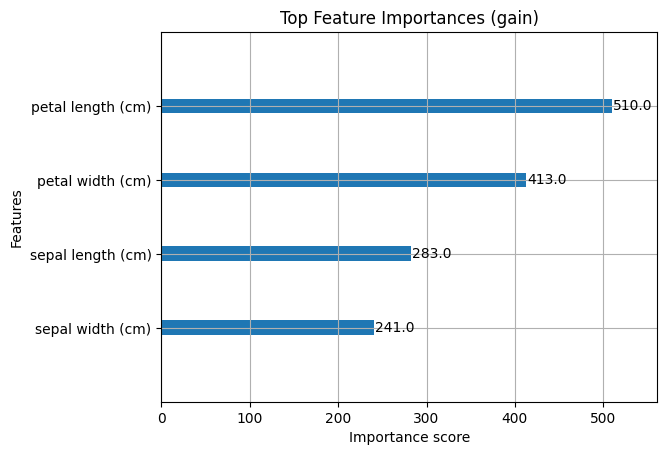

In [6]:

# Works for sklearn API models (clf/reg) and Booster objects
xgb.plot_importance(clf, max_num_features=10)
plt.title("Top Feature Importances (gain)")
plt.show()


## 7) Missing Values & (Optional) Categorical Features

In [7]:

# XGBoost natively handles missing values encoded as np.nan
X_nan = X.copy()
X_nan.iloc[0, 0] = np.nan

clf_nan = XGBClassifier(
    n_estimators=200, max_depth=4, learning_rate=0.1,
    objective="multi:softprob", eval_metric="mlogloss", random_state=0
).fit(X_nan, y)

print("Trained with missing values (np.nan) without imputation.")

# (Optional) Native categorical support (requires recent xgboost)
# We'll try; if not supported, we skip gracefully.
try:
    df_cat = pd.DataFrame({
        "cat": pd.Series(["A","B","A","C","B","A"], dtype="category"),
        "x1":  [1,2,3,4,5,6],
        "y":   [0,1,0,2,1,0]
    })
    Xc = df_cat[["cat","x1"]]
    yc = df_cat["y"]
    cat_model = XGBClassifier(
        tree_method="hist",
        enable_categorical=True,
        eval_metric="mlogloss"
    )
    cat_model.fit(Xc, yc)
    print("Native categorical demo: OK")
except Exception as e:
    print("Native categorical demo skipped:", e)


Trained with missing values (np.nan) without imputation.
Native categorical demo: OK


## 8) Save & Load Models

In [8]:

# Save sklearn API model
clf.save_model("xgb_iris.json")

# Load into a fresh classifier
loaded = XGBClassifier()
loaded.load_model("xgb_iris.json")

print("Loaded model accuracy:", accuracy_score(y_test, loaded.predict(X_test)))


Loaded model accuracy: 0.9



## 9) Practical Tuning Hints (Cheat-Sheet)
- **n_estimators**: start high + use **early_stopping_rounds**.
- **learning_rate (eta)**: lower values (e.g., 0.03–0.1) + more trees.
- **max_depth** / **min_child_weight**: control complexity (deeper → more complex).
- **subsample** / **colsample_bytree**: < 1.0 for regularization & speed.
- **reg_lambda** / **reg_alpha**: L2/L1 regularization to reduce overfitting.
- Prefer **tree_method='hist'** (fast) and **gpu_hist** if GPU available.
- Handle **class imbalance**: `scale_pos_weight` for binary classification.


# **Fin.**